/home/andreasstillits/coding/Leaves1D/PNAS_REVIEW
Info    : Reading 'files/meshes/cylinder_typical.msh'...
Info    : 10 entities
Info    : 7613 nodes
Info    : 44722 elements
Info    : Done reading 'files/meshes/cylinder_typical.msh'
Mean chi: 0.1000, Std chi: 0.0000, A_n: 0.0009
Mean kappa: 1.0000000
Info    : Reading 'files/meshes/cylinder_typical.msh'...
Info    : 10 entities
Info    : 7613 nodes
Info    : 44722 elements
Info    : Done reading 'files/meshes/cylinder_typical.msh'
Mean chi: 0.1000, Std chi: 0.0000, A_n: 0.0009
Mean kappa: 0.9995999
Relative difference in A_n: -1.59 %


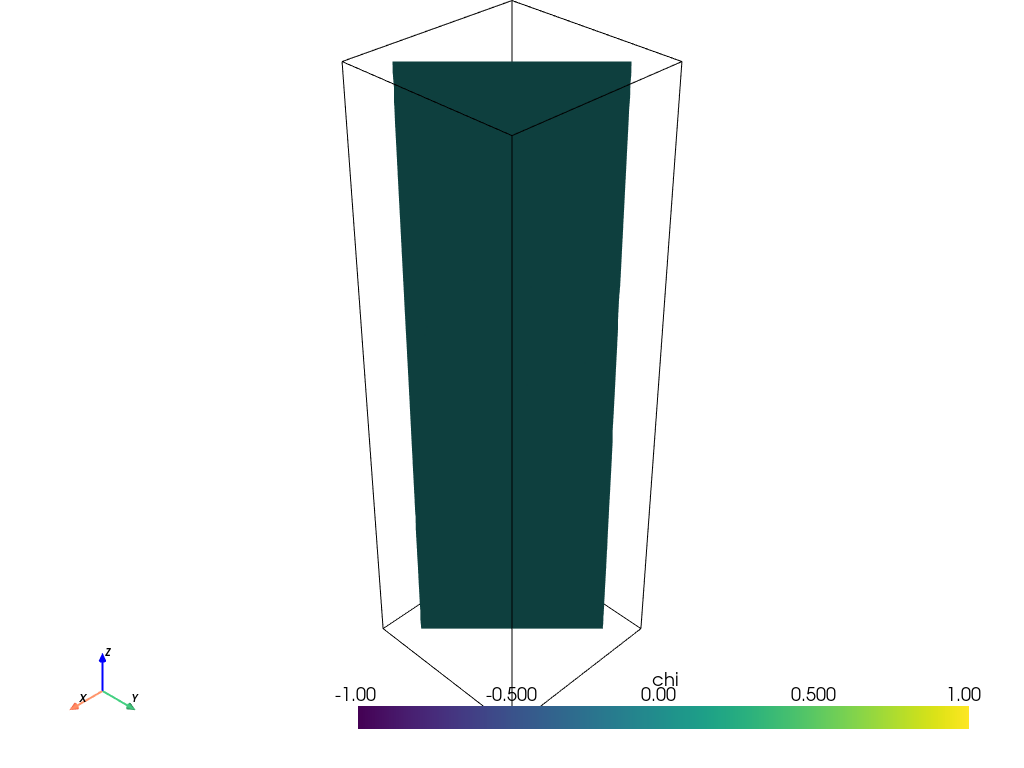

In [ ]:
%cd /home/andreasstillits/coding/Leaves1D/supplementary

from codebase.lateral.solver import Steady3DSolver 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from codebase.utils.plotfunctions import plot_3d_solution 
from dolfinx.io import gmshio
from mpi4py import MPI
from dolfinx import fem, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import ufl
import pyvista as pv 
from dolfinx.plot import vtk_mesh


def plot(mesh, chi, clim: tuple[float, float] = (0.0, 1.0)) -> None:
    topology, cell_types, geometry = vtk_mesh(mesh, mesh.topology.dim)
    grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    grid.point_data["chi"] = chi.x.array.real
    xmin, xmax, ymin, ymax, zmin, zmax = grid.bounds
    # slices = grid.slice_orthogonal(
    #     x=(xmin + xmax) / 2, y=(ymin + ymax) / 2, z=(zmin + zmax) / 2
    # )
    slices = grid.slice(normal=(1,1,0), origin=(0,0,0))
    p = pv.Plotter(notebook=True)
    p.add_mesh(slices, scalars="chi", cmap="viridis", clim=clim)
    p.add_mesh(grid.outline(), color="k")
    p.show_axes()
    p.show()


def solve(params: tuple[float, float, float],
            rho: tuple[float, float, float], 
            mesh_file: str | Path,
            plug_radius: float,
            stomatal_radius: float,
            ) -> None: 
    _tau, _gamma, _chi_ = params
    rho_delta, rho_kappa, rho_lambda = rho

    mesh, cell_tags, facet_tags = gmshio.read_from_msh(
        mesh_file, MPI.COMM_SELF, 0, gdim=3
    )
    #
    AIRSPACE_TAG = 1
    # TOP_TAG = 2
    BOTTOM_TAG = 3
    # CURVED_TAG = 4
    #
    functionspace = fem.functionspace(mesh, ("Lagrange", 1))
    dx = ufl.Measure("dx", domain=mesh, subdomain_data=cell_tags)
    ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tags)

    tau2 = fem.Constant(mesh, default_scalar_type(_tau**2))
    chi_ = fem.Constant(mesh, default_scalar_type(_chi_))

    chi = ufl.TrialFunction(functionspace)
    v = ufl.TestFunction(functionspace)
    x = ufl.SpatialCoordinate(mesh)
    #
    phi = x[0] ** 2 + x[1] ** 2 - stomatal_radius**2  # type: ignore[reportIndexIssue]
    gamma = (
        _gamma
        * (plug_radius / stomatal_radius) ** 2
        * 0.5
        * (1 - ufl.tanh(phi / 0.002 / plug_radius**2))
    )
    # delta 
    maximum = 1 / ((1 - rho_lambda) + rho_lambda * rho_delta)
    minimum = rho_delta * maximum
    offset = 1 - rho_lambda
    delta = minimum + (maximum - minimum) * 0.5 * (
        1 - ufl.tanh((x[2] - offset) / 0.1)
    )

    # kappa
    maximum = 1 / ((1 - rho_lambda) * rho_kappa + rho_lambda)
    minimum = rho_kappa * maximum
    offset = 1 - rho_lambda
    kappa = minimum + (maximum - minimum) * 0.5 * (
        1 + ufl.tanh((x[2] - offset) / 0.1)
    )

    # Weak form
    a = (
        delta * ufl.inner(ufl.grad(chi), ufl.grad(v)) * dx(AIRSPACE_TAG)
        + tau2 * kappa * chi * v * dx(AIRSPACE_TAG)
        + gamma * chi * v * ds(BOTTOM_TAG)
    )

    L = tau2 * kappa * chi_ * v * dx(AIRSPACE_TAG) + gamma * v * ds(BOTTOM_TAG)

    problem = LinearProblem(
        a, L, bcs=[], petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )
    chi_h = problem.solve()

    an = fem.assemble_scalar(fem.form(tau2 * kappa * (chi_h - chi_) * dx(AIRSPACE_TAG))) / (np.pi * plug_radius**2)
    
    mean = fem.assemble_scalar(fem.form(chi_h * dx(AIRSPACE_TAG))) / fem.assemble_scalar(fem.form(1.0 * dx(AIRSPACE_TAG)))
    mean2 = fem.assemble_scalar(fem.form(chi_h**2 * dx(AIRSPACE_TAG))) / fem.assemble_scalar(fem.form(1.0 * dx(AIRSPACE_TAG)))
    std = np.sqrt(mean2 - mean**2)    
    print(f"Mean chi: {mean:.4f}, Std chi: {std:.4f}, A_n: {an:.4f}")
    meanK = fem.assemble_scalar(fem.form(kappa * dx(AIRSPACE_TAG))) / fem.assemble_scalar(fem.form(1.0 * dx(AIRSPACE_TAG)))
    print(f"Mean kappa: {meanK:.7f}")

    return mesh, functionspace, chi_h, an



def calculate_comparison(params: tuple[float, float, float],
                         rho: tuple[float, float, float], 
                         mesh_file: str | Path,
                         plug_radius: float,
                         stomatal_radius: float,
                         ) -> None: 
    # build solver 
    mesh, functionspace, chi_hom, an_hom = solve(params, 
                                        (1.0, 1.0, 0.5), 
                                        mesh_file, 
                                        plug_radius, 
                                        stomatal_radius)
    mesh, functionspace, chi_het, an_het = solve(params,
                                        rho, 
                                        mesh_file, 
                                        plug_radius, 
                                        stomatal_radius)
    print(f"Relative difference in A_n: {(an_hom - an_het)/an_het*100:.2f} %")
    # plot solutions
    chi_diff = fem.Function(functionspace, name="diff")
    chi_diff.x.array[:] = 100*(chi_het.x.array[:] - chi_hom.x.array[:]) / chi_hom.x.array[:]
    chi_diff.x.scatter_forward()
    plot(mesh, chi_diff, clim=(-1, 1))

calculate_comparison((1000, 0.001, 0.1),
                     (0.2, 0.2, 0.5),
                     "files/meshes/cylinder_typical.msh",
                     0.1521256,
                     0.0167539) 



In [ ]:
from codebase.utils.constants import ThreeDimExploration 

c = ThreeDimExploration()

print(c.get_stomatal_radius("typical"))

0.016753926701570682
